In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

In [4]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [5]:
win_id = 5

In [6]:
def extract_one_metric(metrics_all_ntrain, which, thresh=None):
    if thresh is None:
        return {ntrain: {test_cond: [res[which] for res in res_all_trials]
                   for test_cond, res_all_trials in x.iteritems()}
         for ntrain, x in metrics_all_ntrain.iteritems()}
    else:
        return {ntrain: {test_cond: [res[which][thresh] for res in res_all_trials]
                   for test_cond, res_all_trials in x.iteritems()}
         for ntrain, x in metrics_all_ntrain.iteritems()}

In [7]:
def plot_result_wrt_ntrain(test_metrics_all_ntrain, ylabel='', title=''):

    for test_condition in test_metrics_all_ntrain.values()[1].keys():
        ntrains, accs, errs = zip(*sorted([(ntrain, np.mean(x[test_condition]), np.std(x[test_condition]))
              for ntrain, x in test_metrics_all_ntrain.iteritems() if len(x) > 0]))
        plt.errorbar(ntrains, accs, yerr=errs, label=test_condition[1]);
    plt.xlabel('# traing patches');
    plt.ylabel(ylabel);
    plt.title(title);
    plt.legend(loc='upper right');
    plt.ylim([0.5, 1.]);
    plt.xlim([0,16000]);
    plt.show()

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD661" "/home/yuncong/CSHL_labelings_v3/MD661" --exclude "*" --include "*win5*warp*grid_indices_lookup*"
latest timestamp:  01052018122220
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/ChatCryoJane201710" "/home/yuncong/CSHL_labelings_v3/ChatCryoJane201710" --exclude "*" --include "*win5*grid_indices_lookup*"
latest timestamp:  12132017032001


Computing class label to grid indices lookup-table for section 85...
Computing class label to grid indices lookup-table for section 86...
Computing class label to grid indices lookup-table for section 87...
Computing class label to grid indices lookup-table for section 88...
Computing class label to grid indices lookup-table for section 89...
Computing class label to grid indices lookup-table for section 90...
Computing class label to grid indices lookup-table for section 91...
Computing class label to grid indices lookup-table for section 92...
Computing class label to grid indices lookup-table for section 93...
Computing class label to grid indices lookup-table for section 94...
Computing class label to grid indices lookup-table for section 95...
Computing class label to grid indices lookup-table for section 96...
Computing class label to grid indices lookup-table for section 97...
Computing class label to grid indices lookup-table for section 98...
Computing class label to grid indi

Computing class label to grid indices lookup-table for section 159...
MD661, sec 159: 208 patches from label 7N.
MD661, sec 159: 11 patches from label 7N_surround_200_LRt.
MD661, sec 159: 632 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 160...
MD661, sec 160: 189 patches from label 7N.
MD661, sec 160: 8 patches from label 7N_surround_200_LRt.
MD661, sec 160: 631 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 161...
MD661, sec 161: 187 patches from label 7N.
MD661, sec 161: 6 patches from label 7N_surround_200_LRt.
MD661, sec 161: 617 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 162...
MD661, sec 162: 183 patches from label 7N.
MD661, sec 162: 4 patches from label 7N_surround_200_LRt.
MD661, sec 162: 612 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for sect

Computing class label to grid indices lookup-table for section 260...
MD661, sec 260: 0 patches from label 7N.
MD661, sec 260: 432 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 261...
MD661, sec 261: 46 patches from label 7N.
MD661, sec 261: 448 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 262...
MD661, sec 262: 72 patches from label 7N.
MD661, sec 262: 466 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 263...
MD661, sec 263: 136 patches from label 7N.
MD661, sec 263: 509 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 264...
MD661, sec 264: 160 patches from label 7N.
MD661, sec 264: 514 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 265...
MD661, sec 265: 184 patches from label 7N.
MD661,

Computing class label to grid indices lookup-table for section 89...
ChatCryoJane201710, sec 89: 108 patches from label 7N.
ChatCryoJane201710, sec 89: 451 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 90...
ChatCryoJane201710, sec 90: 184 patches from label 7N.
ChatCryoJane201710, sec 90: 535 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 91...
ChatCryoJane201710, sec 91: 209 patches from label 7N.
ChatCryoJane201710, sec 91: 535 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 92...
ChatCryoJane201710, sec 92: 237 patches from label 7N.
ChatCryoJane201710, sec 92: 569 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 93...
ChatCryoJane201710, sec 93: 265 patches from label 7N.
ChatCryoJane201710, sec 93: 586 patches from label 7N_surround_200_noclass.


ChatCryoJane201710, sec 130: 686 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 131...
ChatCryoJane201710, sec 131: 387 patches from label 7N.
ChatCryoJane201710, sec 131: 625 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 132...
ChatCryoJane201710, sec 132: 314 patches from label 7N.
ChatCryoJane201710, sec 132: 577 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 133...
ChatCryoJane201710, sec 133: 242 patches from label 7N.
ChatCryoJane201710, sec 133: 532 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 134...
ChatCryoJane201710, sec 134: 73 patches from label 7N.
ChatCryoJane201710, sec 134: 365 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 135...
Computing class label to grid indices look

Section 140 provides 1 positive patches.
Section 141 provides 24 positive patches.
Section 142 provides 44 positive patches.
Section 143 provides 68 positive patches.
Section 144 provides 110 positive patches.
Section 145 provides 126 positive patches.
Section 146 provides 159 positive patches.
Section 147 provides 172 positive patches.
Section 148 provides 188 positive patches.
Section 149 provides 215 positive patches.
Section 150 provides 219 positive patches.
Section 151 provides 237 positive patches.
Section 152 provides 252 positive patches.
Section 153 provides 255 positive patches.
Section 154 provides 253 positive patches.
Section 155 provides 251 positive patches.
Section 156 provides 246 positive patches.
Section 157 provides 228 positive patches.
Section 158 provides 221 positive patches.
Section 159 provides 208 positive patches.
Section 160 provides 189 positive patches.
Section 161 provides 187 positive patches.
Section 162 provides 183 positive patches.
Section 163 prov

No images are provided. Load instead.
Not using image_cache.
Load image: 18.03 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.64 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 19.05 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.74 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 19.09 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.49 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.63 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 17.47 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 18.46 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 19.62 seconds.
Compute variants: 0.02 seconds


(7760, 1, 224, 224)


Feature computation: 12.98 seconds
Compute variants: 0.01 seconds


(7760, 1, 224, 224)


Feature computation: 13.48 seconds
Compute variants: 0.01 seconds


(7760, 1, 224, 224)


Feature computation: 13.25 seconds
Compute variants: 0.01 seconds


(7760, 1, 224, 224)


Feature computation: 14.01 seconds
Compute variants: 0.01 seconds


(7760, 1, 224, 224)


Feature computation: 14.31 seconds
Compute variants: 0.01 seconds


(7760, 1, 224, 224)


Feature computation: 14.40 seconds
Compute variants: 0.01 seconds


(7760, 1, 224, 224)


Feature computation: 14.28 seconds
Compute variants: 0.01 seconds


(7760, 1, 224, 224)


Feature computation: 14.34 seconds
No images are provided. Load instead.
Not using image_cache.
Load image: 12.38 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 11.82 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 13.03 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 11.43 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.17 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.03 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 11.30 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 11.60 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.57 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.40 seconds.
Compute variants: 0.01 seconds


(12765, 1, 224, 224)


Feature computation: 21.07 seconds
Fitting classifier: 0.02 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.03 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 9.65 seconds
Fitting classifier: 0.60 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 10.01 seconds
Fitting classifier: 0.65 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 9.19 seconds
Fitting classifier: 0.60 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 9.30 seconds
Fitting classifier: 0.60 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 8.20 seconds
Fitting classifier: 0.66 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.61 seconds
Fitting classifier: 0.60 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 8.68 seconds
Fitting classifier: 0.52 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 8.81 seconds
Fitting classifier: 0.54 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 8.96 seconds
Fitting classifier: 0.52 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 8.42 seconds
Fitting classifier: 0.54 seconds


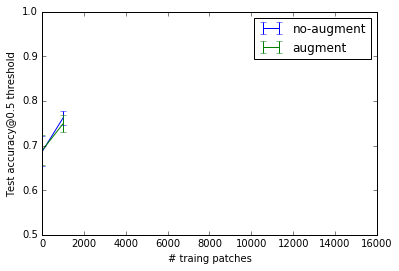

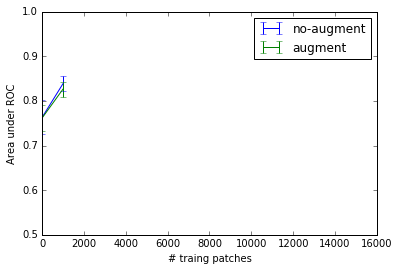

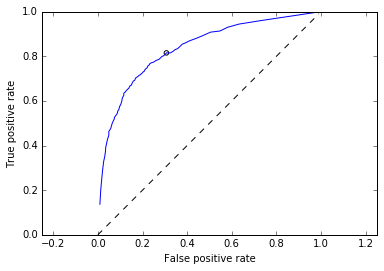

In [24]:
for stack1 in ['MD661']:
    
    stacks = [stack1, 'ChatCryoJane201710']
    
    #############################
    
    sample_locations_allStacks = {stack: grid_parameters_to_sample_locations(win_id_to_gridspec(win_id=5, stack=stack)) 
                              for stack in stacks}
    
    #############################
    
    grid_indices_lookup_allStacks = {}

    for stack in [stack1]:
        try:
            grid_indices_lookup_allStacks[stack] = \
            DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                               by_human=False, timestamp='latest',
                                                               detector_id_f=1)
            
#             grid_indices_lookup_allStacks[stack] = \
#             DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
#                                                                by_human=True, timestamp='latest')
        except Exception as e:
            print e
            sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)


    # stack = 'MD661'
    stack = 'ChatCryoJane201710'
    try:
        grid_indices_lookup_allStacks[stack] = \
        DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                           by_human=True, timestamp='latest')
    except:
        sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)
        
    #############################
    
    from itertools import chain
    all_labels = sorted(list(set(chain.from_iterable(set(grid_indices_lookup_allStacks[st].columns.tolist()) for st in stacks))))
    
    address_multidx = pd.MultiIndex.from_tuples([(stack, sec, grid_idx) 
           for stack in sorted(stacks)
           for sec in np.arange(metadata_cache['section_limits'][stack][0], 
                                metadata_cache['section_limits'][stack][-1]+1)
           for grid_idx in range(len(sample_locations_allStacks[stack]))], 
          names=['stack', 'section', 'grid_idx'])
    
    address_label_df_allStacks = DataFrame(columns=all_labels,
    index=address_multidx, data=False)
    
    # surround_margins = [200, 500]
    surround_margins = [200]
    
    # Option 1: Use the cached file that stores the mapping from grid-indices to labels for speed up.

    for stack in stacks:
    # for stack in ['MD661']:
    # for stack in ['ChatCryoJane201710']:

        grid_index_class_lookup = grid_indices_lookup_allStacks[stack]

        for sec in grid_index_class_lookup.index:
            sys.stderr.write('Computing class label to grid indices lookup-table for section %d...\n' % sec)
            if is_invalid(sec=sec, stack=stack):
                continue

            for label, grid_indices in grid_index_class_lookup.loc[sec].dropna().iteritems():
                if label == 'bg' or label == 'noclass' or 'negative' in label: # Ignore bg, noclass, x_negative
                    continue

                name, side, margin, surr_name = parse_label(label)

                if name == '7N' and (margin is None or (margin is not None and int(margin) in surround_margins)):

                    sys.stderr.write("%s, sec %d: %d patches from label %s.\n" % (stack, sec, len(grid_indices), label))
        #             t = time.time()
                    for grid_idx in grid_indices:
                        address_label_df_allStacks.loc[(stack, sec, grid_idx), label] = True
        #             sys.stderr.write("%.2f s\n" % (time.time()-t))

    del grid_indices_lookup_allStacks
    
    ###################################
    
    # structure = 'Amb'
    structure = '7N'
    # structure = 'SNR'
    positive_labels = [structure]
    negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=200, 
                                          labels_found=address_label_df_allStacks.columns)
    # negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=500, 
    #                                       labels_found=address_label_df_allStacks.columns)
    
    ####################################
    
    train_stacks = [stack1]
    test_stacks = ['ChatCryoJane201710']
    
    train_stack_section_number = {stack1: 10}
    test_stack_section_number = {'ChatCryoJane201710': 10}

    train_stack_stain = {stack1: 'F'}
    test_stack_stain = {'ChatCryoJane201710': 'A'}
    
    positive_addresses_traindata_all_stacks = {}
    negative_addresses_traindata_all_stacks = {}

    for train_stack in train_stacks:

        q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
        all_sections = np.unique(q.loc[train_stack].index.get_level_values('section'))
        train_sections = [] # sections that contain patches of relevant classes.
        for sec in all_sections:
            try:
                if len(q.loc[train_stack, sec].index.values.tolist()) > 0:
                    train_sections.append(sec)
                    print 'Section', sec, 'provides', len(q.loc[train_stack, sec].index.values.tolist()), 'positive patches.'
            except:
                pass

        ###################################################################################

        n_train_sections = train_stack_section_number[train_stack]
        # n_train_sections = 10
        # n_train_sections = len(train_sections)

        if train_stack_stain[train_stack] == 'F':
            neurotrace_sections = []
            nissl_sections = []
            for sec in train_sections:
                if metadata_cache['sections_to_filenames'][train_stack][sec].split('-')[1][0] == 'F':
                    neurotrace_sections.append(sec)
                else:
                    nissl_sections.append(sec)
            random_train_sections = np.random.choice(neurotrace_sections, min(len(neurotrace_sections), n_train_sections), replace=False)
        else:
            random_train_sections = np.random.choice(train_sections, min(len(train_sections), n_train_sections), replace=False)

        positive_addresses_traindata_all_stacks[train_stack] = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[[train_stack], random_train_sections, :].index.values.tolist() 
        negative_addresses_traindata_all_stacks[train_stack] = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[[train_stack], random_train_sections, :].index.values.tolist() 

    positive_addresses_traindata = sum(positive_addresses_traindata_all_stacks.values(), [])
    negative_addresses_traindata = sum(negative_addresses_traindata_all_stacks.values(), [])

    print '# positive train =', len(positive_addresses_traindata)
    print '# negative train =', len(negative_addresses_traindata)

    del positive_addresses_traindata_all_stacks, negative_addresses_traindata_all_stacks
    
    positive_addresses_testdata_all_stacks = {}
    negative_addresses_testdata_all_stacks = {}

    for test_stack in test_stacks:

        q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
        all_sections = np.unique(q.loc[test_stack].index.get_level_values('section'))
        test_sections = [] # sections that contain patches of relevant classes.
        for sec in all_sections:
            try:
                if len(q.loc[test_stack, sec].index.values.tolist()) > 0:
                    test_sections.append(sec)
                    print 'Section', sec, 'provides', len(q.loc[test_stack, sec].index.values.tolist()), 'positive patches.'
            except:
                pass

        #####################################################################################

        n_test_sections = test_stack_section_number[test_stack]
    #     n_test_sections = 10
        # n_test_sections = len(test_sections)

        if test_stack_stain[test_stack] == 'F':

            neurotrace_sections = []
            nissl_sections = []
            for sec in test_sections:
                if metadata_cache['sections_to_filenames'][test_stack][sec].split('-')[1][0] == 'F':
                    neurotrace_sections.append(sec)
                else:
                    nissl_sections.append(sec)
            random_test_sections = np.random.choice(neurotrace_sections, min(len(neurotrace_sections), n_test_sections), replace=False)
        else:
            random_test_sections = np.random.choice(test_sections, min(len(test_sections), n_test_sections), replace=False)

        positive_addresses_testdata_all_stacks[test_stack] = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[[test_stack], random_test_sections, :].index.values.tolist()
        negative_addresses_testdata_all_stacks[test_stack] = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[[test_stack], random_test_sections, :].index.values.tolist()

    positive_addresses_testdata = sum(positive_addresses_testdata_all_stacks.values(), [])
    negative_addresses_testdata = sum(negative_addresses_testdata_all_stacks.values(), [])

    print '# positive test =', len(positive_addresses_testdata)
    print '# negative test =', len(negative_addresses_testdata)

    del positive_addresses_testdata_all_stacks, negative_addresses_testdata_all_stacks
    
    # schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)']
    # schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)', 'median_curve']
    # schemes = ['normalize_mu_region_sigma_wholeImage_(-1,5)']
    # schemes = ['stretch_min_max']
    # schemes = [None, 'stretch_min_max']
    # schemes = ['none']
    # schemes = [None, 'median_curve']
    # transforms = ['transform%d' % i for i in range(8)]
    # scheme_transform_multiindex = pd.MultiIndex.from_product([schemes, transforms])

    # features_dict = {(scheme, tfv): {} for scheme in schemes for tfv in transforms}
    features_dict = defaultdict(dict)
    
    # train_scheme = 'stretch_min_max'
    # train_scheme = 'normalize_mu_sigma_global_(-1,5)'
    train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
    # train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
    # train_scheme = 'none'
    addresses_to_compute = positive_addresses_traindata + negative_addresses_traindata

    patches_with_desired_label = \
    extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
    #                                                     images={('MD661', 199): img},
                                                  win_id=win_id, 
                                                normalization_scheme=train_scheme,
                                                 location_or_grid_index='grid_index')

    #     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

    # for variant in [0]:
    for variant in range(8):

        t = time.time()
    #             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
        patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
        sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

        t = time.time()
        features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                     mean_img=mean_img, 
    #                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                     batch_size=batch_size)
        sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

        for i, f in enumerate(features):
    #             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
            features_dict[(train_scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f
        
    
    # test_scheme = 'stretch_min_max'
    # test_scheme = 'normalize_mu_sigma_global_(-1,5)'
    test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
    # test_scheme = 'median_curve'
    # test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
    # test_scheme = 'none'
    addresses_to_compute = positive_addresses_testdata + negative_addresses_testdata

    patches_with_desired_label = \
    extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
    #                                                     images={('MD661', 199): img},
                                                  win_id=win_id, 
                                                normalization_scheme=test_scheme,
                                                 location_or_grid_index='grid_index')

    #     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

    for variant in [0]:
    # for variant in range(8):

        t = time.time()
    #             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
        patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
        sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

        t = time.time()
        features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                     mean_img=mean_img, 
    #                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                     batch_size=batch_size)
        sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

        for i, f in enumerate(features):
    #             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
            features_dict[(test_scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f
        
    ###########################################################
    
    # n_train_list = [10, 100, 200, 500, 1000, 2000, 5000, 10000, 15000]
    n_train_list = [10, 1000]
    test_metrics_all_ntrain = defaultdict(lambda: defaultdict(list))
    train_metrics_all_ntrain = defaultdict(lambda: defaultdict(list))

    for n_train in n_train_list:

        for trial in range(10):

            # If train and test data are from different sets
        #     n_train_pos = 5000
            n_train_pos = n_train
            if len(positive_addresses_traindata) < n_train_pos:
                continue
            training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)
            n_test_pos = 1000
            test_pos_indices = np.random.choice(range(len(positive_addresses_testdata)),
                                                size=min(len(positive_addresses_testdata), n_test_pos), 
                                                replace=False)

            # If train and test are from same set
        #     n_pos_total = len(positive_addresses)
        #     n_train_pos = 1000
        #     training_pos_indices = np.random.choice(range(n_pos_total), n_train_pos, replace=False)
        #     test_pos_indices = np.random.choice(np.setdiff1d(range(n_pos_total), training_pos_indices),
        #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
        #     n_test_pos = len(test_pos_indices)

            ###############

            # If train and test data are from different sets
        #     n_train_neg = 5000
            n_train_neg = n_train
            training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)
            n_test_neg = 1000
            test_neg_indices = np.random.choice(range(len(negative_addresses_testdata)),
                                                size=min(len(negative_addresses_testdata), n_test_neg), 
                                                replace=False)

            # If train and test are from same set
        #     n_neg_total = len(negative_addresses)
        #     n_train_neg = 1000
        #     training_neg_indices = np.random.choice(range(n_neg_total), n_train_neg, replace=False)
        #     test_neg_indices = np.random.choice(np.setdiff1d(range(n_neg_total), training_neg_indices), 
        #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
        #     n_test_neg = len(test_neg_indices)

            print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
            print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

            ################

            # If train and test data are from different sets
            addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
            addresses_test_pos = [positive_addresses_testdata[i] for i in test_pos_indices]
            addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]
            addresses_test_neg = [negative_addresses_testdata[i] for i in test_neg_indices]

            # If train and test data are from same set
        #     addresses_train_pos = [positive_addresses[i] for i in training_pos_indices]
        #     addresses_test_pos = [positive_addresses[i] for i in test_pos_indices]
        #     addresses_train_neg = [negative_addresses[i] for i in training_neg_indices]
        #     addresses_test_neg = [negative_addresses[i] for i in test_neg_indices]

            #################

            for augment_training in [True, False]:
    #         for augment_training in [False]:

                feature_classifier_alg = 'lr'
        #             feature_classifier_alg = 'xgb2'
        #             feature_classifier_alg = 'lin_svc'
        #             feature_classifier_alg = 'lin_svc_calib'
                sample_weights = None   

                if augment_training:
                    train_transforms = range(8)
                else:
                    train_transforms = range(1)

                test_transforms = range(1)

                features_train_pos = {(train_scheme, 'transform%d'%tf_variant): 
                                      [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                                       for addr in addresses_train_pos]
                                          for tf_variant in train_transforms}
                features_train_neg = {(train_scheme, 'transform%d'%tf_variant): 
                                      [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                                       for addr in addresses_train_neg]
                                          for tf_variant in train_transforms}
                features_test_pos = {(test_scheme, 'transform%d'%tf_variant): 
                                     [features_dict[(test_scheme, 'transform%d'%tf_variant)][addr] 
                                      for addr in addresses_test_pos]
                                         for tf_variant in test_transforms}
                features_test_neg = {(test_scheme, 'transform%d'%tf_variant): 
                                     [features_dict[(test_scheme, 'transform%d'%tf_variant)][addr]
                                      for addr in addresses_test_neg]
                                         for tf_variant in test_transforms}    

                if augment_training:

                    train_data_list = []
                    train_label_list = []
                    for tf in range(8):
                        train_data = np.r_[features_train_pos[(train_scheme,'transform%d'%tf)], 
                                           features_train_neg[(train_scheme,'transform%d'%tf)]]
                        train_data_list.append(train_data)

                        train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform%d'%tf)]), )), 
                                             -np.ones((len(features_train_neg[(train_scheme,'transform%d'%tf)]), ))]
                        train_label_list.append(train_labels)

                    train_data = np.concatenate(train_data_list)
                    train_labels = np.concatenate(train_label_list)        
                else:

                    train_data = np.r_[features_train_pos[(train_scheme,'transform0')], 
                                       features_train_neg[(train_scheme,'transform0')]]
                    train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform0')]), )), 
                                         -np.ones((len(features_train_neg[(train_scheme,'transform0')]), ))]


                clf = train_binary_classifier(train_data, train_labels,
                                       alg=feature_classifier_alg, 
                                       sample_weights=sample_weights)

                #     trained_classifiers[structure] = clf

                #         clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
                #         create_parent_dir_if_not_exists(clf_fp)
                #         joblib.dump(clf, clf_fp)
                #         upload_to_s3(clf_fp)

                train_metrics = compute_classification_metrics(clf.predict_proba(train_data)[:,1], train_labels)
                train_metrics_all_ntrain[n_train][(train_scheme, 'augment' if augment_training else 'no-augment')].append(train_metrics)

                test_data = np.r_[features_test_pos[(test_scheme,'transform0')], features_test_neg[(test_scheme,'transform0')]]
                test_labels = np.r_[np.ones((len(features_test_pos[(test_scheme,'transform0')]), )), 
                                     -np.ones((len(features_test_neg[(test_scheme,'transform0')]), ))]
                test_metrics = compute_classification_metrics(clf.predict_proba(test_data)[:,1], test_labels)
    #             print "acc@0.5 = %.3f, acc@opt = %.3f, opt_thresh = %.3f, auroc = %.3f, auprc = %.3f" % \
    #             (test_metrics['acc'][0.5], test_metrics['acc'][test_metrics['opt_thresh']], test_metrics['opt_thresh'], test_metrics['auroc'], test_metrics['auprc'])

                test_metrics_all_ntrain[n_train][(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics)

    train_metrics_all_ntrain.default_factory = None
    test_metrics_all_ntrain.default_factory = None
    
    
    plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'acc', 0.5), ylabel='Test accuracy@0.5 threshold');
    plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'auroc'), ylabel='Area under ROC');

    plot_roc_curve(test_metrics_all_ntrain[1000][('normalize_mu_region_sigma_wholeImage_(-1,5)',
                  'augment')][0]['fp'], 
                   test_metrics_all_ntrain[1000][('normalize_mu_region_sigma_wholeImage_(-1,5)',
                  'augment')][0]['tp'], 
                  test_metrics_all_ntrain[1000][('normalize_mu_region_sigma_wholeImage_(-1,5)',
                  'augment')][0]['opt_thresh']);
    
    import uuid

    result = {
        'n_train_sections': train_stack_section_number,
        'n_test_sections': test_stack_section_number,
        'train_stain': train_stack_stain,
        'test_stain': test_stack_stain,
        'train_stack': train_stack,
        'test_stack': test_stack,
        'test_scheme': test_scheme,
        'train_scheme': train_scheme,
        'train_metrics_all_ntrain': train_metrics_all_ntrain,
        'test_metrics_all_ntrain': test_metrics_all_ntrain
    }

    create_if_not_exists(ROOT_DIR + '/assessment_results_v2/')
    save_pickle(result, ROOT_DIR + '/assessment_results_v2/assessment_result_%s.pkl' % str(uuid.uuid1()).split('-')[0])